In [12]:
from xflowrl.util.util import plot_to_image, plot_xfer_heatmap
from collections import OrderedDict
import seaborn as sns
import json
import pandas as pd

In [5]:
xfers_applied = {'100': 10, '90': 30, '3': 5, '60': 15}
print({'xfer': [int(k) for k in xfers_applied.keys()], 'count': [v for _, v in xfers_applied.items()] })
xfers_applied_1 = {'xfer': [100, 67, 9, 151], 'count': [10, 15, 5, 7]}

{'xfer': [100, 90, 3, 60], 'count': [10, 30, 5, 15]}


   xfer  count
0   100     10
1    67     15
2     9      5
3   151      7


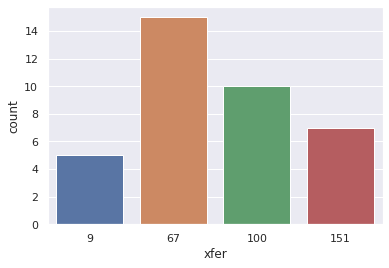

In [3]:
fig = plot_xfer_heatmap(xfers_applied)

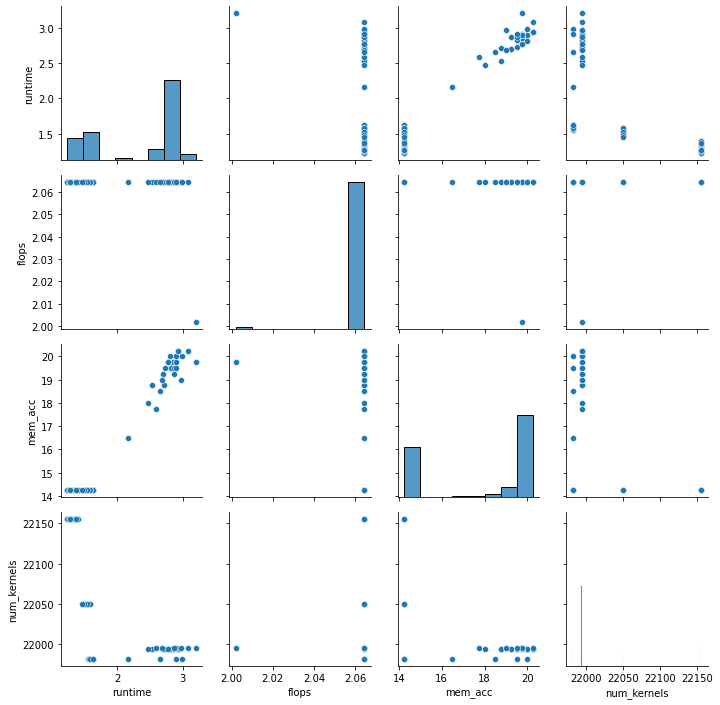

In [15]:
timestamp = '20210309-161428'
graph = 'BERT'
path = f'../logs/xflowrl/{graph}/{timestamp}/runtime_info.json'


with open(path, 'r', encoding='utf-8') as f:
    detailed_costs = json.load(f)

data = dict(runtime=[], flops=[], mem_acc=[], num_kernels=[])

for e in detailed_costs:
    for k, v in e.items():
        data[k].append(v)
        
df = pd.DataFrame.from_dict(data)

g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)